In [1]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet sentencepiece
!pip install --quiet git+https://github.com/csebuetnlp/normalizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 KB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from normalizer import normalize
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW, AutoModelForSeq2SeqLM, AutoTokenizer as Tokenizer)

In [3]:
pl.seed_everything (42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/BANGLA GPT/bengali_XLSum_v2.0.tar.bz2' -r '/content/'

In [6]:
!tar xjf /content/bengali_XLSum_v2.0.tar.bz2

## **Train Data**

In [7]:
fname = '/content/dataset/bengali_train.jsonl'
with open(fname) as f:
    data = [json.loads(line) for line in f]

# Convert the list of dictionaries to a Pandas dataframe
train_df = pd.DataFrame(data)

# Print the dataframe
train_df = train_df[['title','summary','text']]
train_df

,title,summary,text
0,দুর্গাপূজার সময়ে যেভাবে শোক পালন করেন 'মহিষাস...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...
1,রাশিয়ায় ক্ষমতার ২০ বছর যেভাবে কেটেছে ভ্লাদিম...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...
2,সংসদ নির্বাচন: বরিশালে ছয়টি আসন কিন্তু সবার দ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...
3,সর্বকালের সর্বশ্রেষ্ঠ বাঙালি: বিবিসি বাংলার জর...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...
4,৭ই মার্চের ভাষণ: ৫০ বছর আগে রেসকোর্স ময়দানে উ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...
...,...,...,...
8097,ট্রাম্পের বোধশক্তি যাচাইয়ের টেস্টে পাশ করবেন তো?,আরো পড়ুন:,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...
8098,মঙ্গল গ্রহে প্রাণের অস্তিত্ব সম্পর্কে যা জানা ...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...
8099,কীভাবে বুঝবেন আপনার সন্তান কিশোর গ্যাং কালচারে...,ঘটনা এক:,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...
8100,সৌদি আরব - ইরান দ্বন্দ্ব: কে কার বন্ধু?,সৌদি আরব,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...


In [8]:
train_df['len_summary'] = train_df['summary'].apply(lambda x: len(x.split()))
train_df['len_text'] = train_df['text'].apply(lambda x: len(x.split()))

In [9]:
train_df

,title,summary,text,len_summary,len_text
0,দুর্গাপূজার সময়ে যেভাবে শোক পালন করেন 'মহিষাস...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,19,1410
1,রাশিয়ায় ক্ষমতার ২০ বছর যেভাবে কেটেছে ভ্লাদিম...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,10,991
2,সংসদ নির্বাচন: বরিশালে ছয়টি আসন কিন্তু সবার দ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,19,1054
3,সর্বকালের সর্বশ্রেষ্ঠ বাঙালি: বিবিসি বাংলার জর...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,60,1338
4,৭ই মার্চের ভাষণ: ৫০ বছর আগে রেসকোর্স ময়দানে উ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,33,84
...,...,...,...,...,...
8097,ট্রাম্পের বোধশক্তি যাচাইয়ের টেস্টে পাশ করবেন তো?,আরো পড়ুন:,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,2,7
8098,মঙ্গল গ্রহে প্রাণের অস্তিত্ব সম্পর্কে যা জানা ...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,2,56
8099,কীভাবে বুঝবেন আপনার সন্তান কিশোর গ্যাং কালচারে...,ঘটনা এক:,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,2,1327
8100,সৌদি আরব - ইরান দ্বন্দ্ব: কে কার বন্ধু?,সৌদি আরব,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,2,782


In [10]:
max_index = train_df['len_summary'].idxmax()
sample = train_df.iloc[max_index]
sample['summary']

"ফরাসি প্রেসিডেন্ট এমানুয়েল ম্যাক্রঁর সাম্প্রতিক বক্তব্যকে ঘিরে এবং ফ্রান্সে ইসলামের নবীর কার্টুন প্রকাশ করা নিয়ে বাংলাদেশসহ বিভিন্ন দেশে প্রতিবাদ হচ্ছে। সে বিষয় দিয়ে আজকে শুরু করছি, প্রথমে লিখেছেন খুলনার পাইকগাছা থেকে আরিফুল ইসলাম: ''ফ্রান্সে এক শিক্ষক ক্লাসে শিক্ষার্থীদের মহানবী হযরত মোহাম্মদ (সাল্লেল লাহু আলয়হে ওয়াসাল্লাম)-এর ব্যাঙ্গ কার্টুন চিত্র দেখানোর পর, এক মুসলিম তরুণ তাকে শিরশ্ছেদ করে। তা নিয়ে সারা মুসলিম বিশ্বে ব্যাপক আলোচনা চলছে। সেই শিক্ষক স্যামুয়েল প্যাটি মত প্রকাশের স্বাধীনতা নামে নবীর ব্যঙ্গ কার্টুন কীভাবে দেখায়? নিশ্চয় ফরা সি আইনে মুসলমানদের বিরুদ্ধে বিদ্বেষ ছড়ানোর কোন বিচার হয় না, সেই জন্য ফরাসি ম্যাগাজিন শার্লি এব্দো বার বার নবীর কার্টুন অঙ্কন করে । অন্যদিকে ইমানুয়েল ম্যাক্রঁ নবীর ব্যঙ্গাত্মক কার্টুন প্রত্যাহার না করার সিদ্ধান্ত নিয়ে গোটা ফ্রান্স ও মুসলিমদের উস্কানি দিচ্ছে।''"

In [11]:
sample['len_summary']

119

In [12]:
min_index = train_df['len_summary'].idxmin()
sample = train_df.iloc[min_index]
sample['summary']

'আরো পড়ুন:'

In [13]:
sample['len_summary']

2

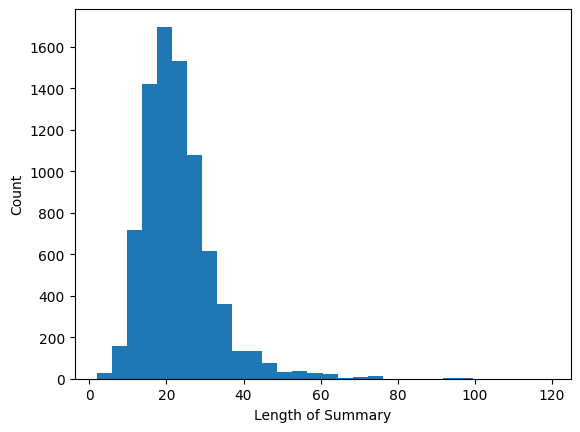

In [14]:
# Plot histogram of length column
plt.hist(train_df['len_summary'], bins=30)
# Set x and y labels
plt.xlabel('Length of Summary')
plt.ylabel('Count')

# Show the plot
plt.show()

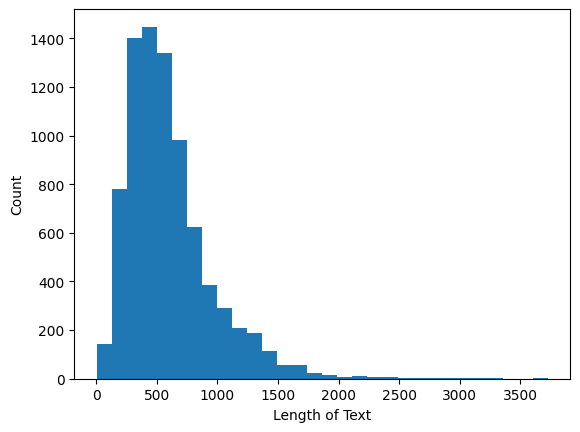

In [15]:
# Plot histogram of length column
plt.hist(train_df['len_text'], bins=30)
# Set x and y labels
plt.xlabel('Length of Text')
plt.ylabel('Count')

# Show the plot
plt.show()

In [16]:
num_short_summaries = (train_df['len_summary'] <= 3).sum()
num_short_summaries

6

In [17]:
train_df = train_df[train_df['len_summary'] > 3]

In [18]:
train_df.shape

(8096, 5)

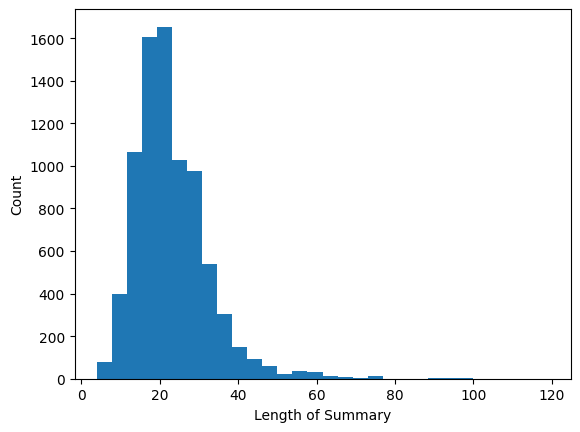

In [19]:
# Plot histogram of length column
plt.hist(train_df['len_summary'], bins=30)
# Set x and y labels
plt.xlabel('Length of Summary')
plt.ylabel('Count')

# Show the plot
plt.show()

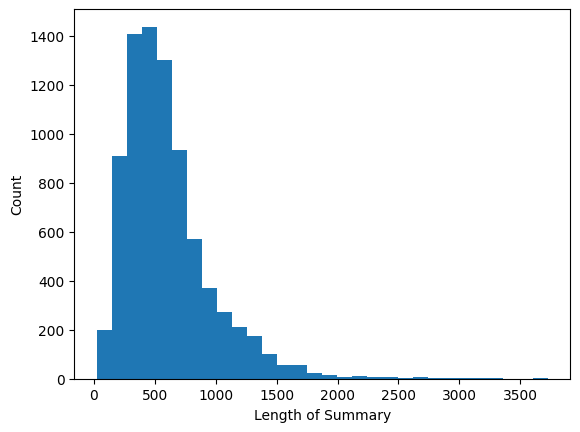

In [20]:
# Plot histogram of length column
plt.hist(train_df['len_text'], bins=30)
# Set x and y labels
plt.xlabel('Length of Summary')
plt.ylabel('Count')

# Show the plot
plt.show()

##**Val Data**

In [21]:
fname = '/content/dataset/bengali_val.jsonl'
with open(fname) as f:
    data = [json.loads(line) for line in f]

# Convert the list of dictionaries to a Pandas dataframe
val_df = pd.DataFrame(data)

# Print the dataframe
val_df = val_df[['title','summary','text']]
val_df

,title,summary,text
0,জামাল খাসোগজি হত্যা: সৌদি রাজতন্ত্রের সমালোচক ...,২০১৫ থেকে ২০১৭ সাল পর্যন্ত ইউরোপে বসবাসরত তিনজ...,"প্রিন্স তুর্কি, প্রিন্স সুলতান আর প্রিন্স সাইফ..."
1,বাংলাদেশসহ নানা দেশে ম্যালেরিয়া বাড়ায় উদ্বেগ,গত ১০ বছরের মধ্যে এই প্রথমবারের মতো বিশ্বে ম্য...,ম্যালেরিয়া ছড়ায় মশাবাহিত একরকম পরজীবী জীবাণ...
2,ভ্রুণের মধ্যে অ্যালকোহল সিনড্রোম,ভ্রুণের মধ্যে অ্যালকোহল সিনড্রোম-বিশ্বের মধ্যে...,যেসব মায়েরা গর্ভাবস্থায় মদ্যপান করেন তাদের স...
3,চোখে টিয়ারশেলের আঘাত পাওয়া সিদ্দিকুর কি দৃষ্...,পুলিশের ছোড়া টিয়ারশেলের আঘাতে আহত ছাত্র মোহা...,জাতীয় চক্ষুবিজ্ঞান ইন্সটিটিউট ও হাসপাতাল জাতী...
4,রাস্তায় সাইনবোর্ড লাগিয়ে বান্ধবীর কাছে ক্ষমা...,কথা ছিল সে আসবে শুক্রবার। তার আগেই এক দফা ঝগড়...,শহর ছেয়ে গেছে এমন বিলবোর্ডে। এসব ভাবতে ভাবতে ...
...,...,...,...
1007,ইয়েমেন লড়াই: সৌদি অভিযানের বিরুদ্ধে অবস্থান ...,মার্কিন যুক্তরাষ্ট্রের সেনেট ইয়েমেনে সৌদি আরব...,মোহাম্মদ বিন সালমান ও প্রেসিডেন্ট ট্রাম্প। মার...
1008,গণমাধ্যমের স্বাধীনতাসহ সমালোচনার সকল ক্ষেত্রেই...,গণমাধ্যমের বাকস্বাধীনতা সহ অন্যান্য যেসব বিষয়...,গত বছরে নিরাপদ সড়ক নিশ্চিত করার দাবিতে হওয়া ...
1009,বাংলাদেশের মানুষের ভারতবিদ্বেষ কি শুধু ক্রিকেট...,বিশ্বকাপ ক্রিকেটের সেমিফাইনালে নিউজিল্যান্ডের ...,বাংলাদেশের মানুষের ভারতবিদ্বেষ কি শুধুই ক্রিকে...
1010,ভারতে ‘দুই সন্তান নীতি’ চান বিজেপির একশরও বেশি...,ভারতে জনসংখ্যা নিয়ন্ত্রণের লক্ষ্যে যাতে 'দুই ...,"দুই সন্তান নীতির পক্ষে ভারতে আন্দোলন। দিল্লি, ..."


In [22]:
val_df['len_summary'] = val_df['summary'].apply(lambda x: len(x.split()))
val_df['len_text'] = val_df['text'].apply(lambda x: len(x.split()))

In [23]:
val_df

,title,summary,text,len_summary,len_text
0,জামাল খাসোগজি হত্যা: সৌদি রাজতন্ত্রের সমালোচক ...,২০১৫ থেকে ২০১৭ সাল পর্যন্ত ইউরোপে বসবাসরত তিনজ...,"প্রিন্স তুর্কি, প্রিন্স সুলতান আর প্রিন্স সাইফ...",19,655
1,বাংলাদেশসহ নানা দেশে ম্যালেরিয়া বাড়ায় উদ্বেগ,গত ১০ বছরের মধ্যে এই প্রথমবারের মতো বিশ্বে ম্য...,ম্যালেরিয়া ছড়ায় মশাবাহিত একরকম পরজীবী জীবাণ...,15,298
2,ভ্রুণের মধ্যে অ্যালকোহল সিনড্রোম,ভ্রুণের মধ্যে অ্যালকোহল সিনড্রোম-বিশ্বের মধ্যে...,যেসব মায়েরা গর্ভাবস্থায় মদ্যপান করেন তাদের স...,16,395
3,চোখে টিয়ারশেলের আঘাত পাওয়া সিদ্দিকুর কি দৃষ্...,পুলিশের ছোড়া টিয়ারশেলের আঘাতে আহত ছাত্র মোহা...,জাতীয় চক্ষুবিজ্ঞান ইন্সটিটিউট ও হাসপাতাল জাতী...,27,241
4,রাস্তায় সাইনবোর্ড লাগিয়ে বান্ধবীর কাছে ক্ষমা...,কথা ছিল সে আসবে শুক্রবার। তার আগেই এক দফা ঝগড়...,শহর ছেয়ে গেছে এমন বিলবোর্ডে। এসব ভাবতে ভাবতে ...,22,373
...,...,...,...,...,...
1007,ইয়েমেন লড়াই: সৌদি অভিযানের বিরুদ্ধে অবস্থান ...,মার্কিন যুক্তরাষ্ট্রের সেনেট ইয়েমেনে সৌদি আরব...,মোহাম্মদ বিন সালমান ও প্রেসিডেন্ট ট্রাম্প। মার...,19,365
1008,গণমাধ্যমের স্বাধীনতাসহ সমালোচনার সকল ক্ষেত্রেই...,গণমাধ্যমের বাকস্বাধীনতা সহ অন্যান্য যেসব বিষয়...,গত বছরে নিরাপদ সড়ক নিশ্চিত করার দাবিতে হওয়া ...,27,531
1009,বাংলাদেশের মানুষের ভারতবিদ্বেষ কি শুধু ক্রিকেট...,বিশ্বকাপ ক্রিকেটের সেমিফাইনালে নিউজিল্যান্ডের ...,বাংলাদেশের মানুষের ভারতবিদ্বেষ কি শুধুই ক্রিকে...,19,570
1010,ভারতে ‘দুই সন্তান নীতি’ চান বিজেপির একশরও বেশি...,ভারতে জনসংখ্যা নিয়ন্ত্রণের লক্ষ্যে যাতে 'দুই ...,"দুই সন্তান নীতির পক্ষে ভারতে আন্দোলন। দিল্লি, ...",21,502


In [24]:
max_index = val_df['len_summary'].idxmax()
sample = val_df.iloc[max_index]
sample['summary']

'সরকার প্রতিদিনের যে হিসেব দিচ্ছে তাতে ঢাকায় শনাক্ত হওয়া কোভিড-১৯ আক্রান্তের সংখ্যা ৭০ হাজার। কিন্তু সরকারের একটি বিভাগ একটি জরিপ করে যে হিসেব দিচ্ছে, তাতে ঢাকার সংক্রমিতের সংখ্যা বহু বহু গুন বেশি। ঢাকার জনসংখ্যা বিবেচনায় এনে হিসেব করলে ১৬ লাখের কম হবে না।'

In [25]:
sample['len_summary']

43

In [26]:
min_index = val_df['len_summary'].idxmin()
sample = val_df.iloc[min_index]
sample['summary']

'(ভিক্টোরিয়া ডার্বিশায়ার প্রোগ্রামের জন্য জেন ম্যাকেঞ্জির প্রতিবেদন)'

In [27]:
sample['len_summary']

7

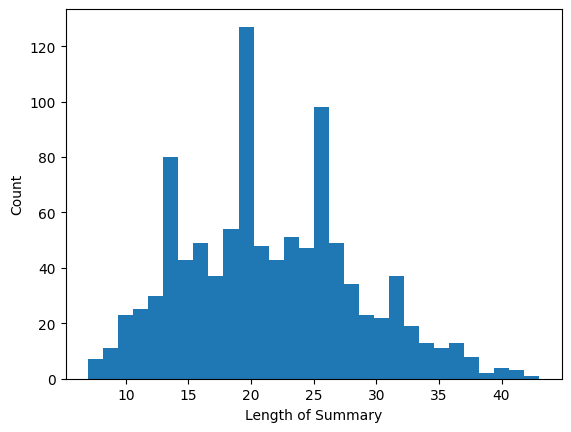

In [28]:
# Plot histogram of length column
plt.hist(val_df['len_summary'], bins=30)
# Set x and y labels
plt.xlabel('Length of Summary')
plt.ylabel('Count')

# Show the plot
plt.show()

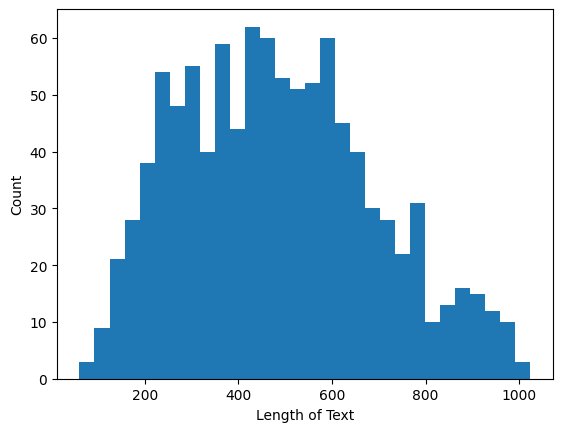

In [29]:
# Plot histogram of length column
plt.hist(val_df['len_text'], bins=30)
# Set x and y labels
plt.xlabel('Length of Text')
plt.ylabel('Count')

# Show the plot
plt.show()

## **Test Data**

In [30]:
fname = '/content/dataset/bengali_test.jsonl'
with open(fname) as f:
    data = [json.loads(line) for line in f]

# Convert the list of dictionaries to a Pandas dataframe
test_df = pd.DataFrame(data)

# Print the dataframe
test_df = test_df[['title','summary','text']]
test_df

,title,summary,text
0,চীন ১০ লাখ উইগুর মুসলিমকে আটকে রেখেছে - জাতিসং...,জাতিসংঘের মানবাধিকার বিষয়ক কমিটি জেনেভাতে চীন...,আটক স্বজনদের আইডি কার্ড হাতে উইগুর নারীদের বিক...
1,"কোকা-কোলা, পেপসি নিষিদ্ধ হলো তামিলনাডুতে",ভারতের দক্ষিণাঞ্চলীয় রাজ্য তামিলনাডুর ব্যবসায...,"ভারতের অন্য অঞ্চলেও কোক, পেপসি নিষিদ্ধ করার দা..."
2,ডেঙ্গু পরিস্থিতি: হাসপাতালে ভর্তির দরকার না থা...,"স্বাস্থ্য অধিদপ্তরের হিসাব মতে, গত ২৪ ঘণ্টায় ...",সোহরাওয়ার্দী হাসপাতালের চিত্র সাধারণত সেপ্টেম...
3,ডোনাল্ড ট্রাম্প: আমেরিকান প্রেসিডেন্টের পোস্ট ...,এই প্রথম সামাজিক মাধ্যমের বিশাল প্রতিষ্ঠান টুই...,ডোনাল্ড ট্রাম্প অভিযোগ করেছেন টু্‌ইটার আমেরিকা...
4,বাংলাদেশে বন্যার প্রকোপ: ২৪ ঘণ্টায় ডুবে যাবে ...,বাংলাদেশের বন্যা পূর্বাভাস এবং সতর্কীকরণ কেন্দ...,বন্যার প্রকোপ ছড়িয়ে পড়ছে সারা দেশে। বাংলাদে...
...,...,...,...
1007,"করোনাভাইরাস: মহামারির আশঙ্কা, বিশ্বজুড়ে আসতে ...",করোনাভাইরাসে আক্রান্ত হয়ে মৃত্যুর সংখ্যা ১৭০ ...,বিশ্ব স্বাস্থ্য সংস্থা বলছে মহামারী আকারে পুরো...
1008,বুনো হাতিটির পেছনে ভারত-বাংলাদেশের বনকর্মীরা,বাংলাদেশের জামালপুরের একটি চরে আটকে থাকা ভারতী...,জামালপুরের প্রত্যন্ত চরে আটকে রয়েছে ভারতীয় এ...
1009,সৌদি আরব নারীদের পুরুষ অভিভাবক ছাড়া একা বিদেশ...,এখন থেকে সৌদি আরবের নারীরা কোনো পুরুষ অভিভাবকে...,ভ্রমণের অধিকারের হিসেবে সৌদি আরবের নারীদেরকে প...
1010,দিল্লীতে কিশোরদের ইনস্টাগ্রাম গ্রুপে গণধর্ষণের...,ইনস্টাগ্রাম গ্রুপ চ্যাটে অপ্রাপ্তবয়স্ক মেয়েদ...,মেয়েদের নিয়ে যৌন হয়রানিমূলক মন্তব্য করায় গ...


In [31]:
test_df['len_summary'] = test_df['summary'].apply(lambda x: len(x.split()))
test_df['len_text'] = test_df['text'].apply(lambda x: len(x.split()))

In [32]:
test_df

,title,summary,text,len_summary,len_text
0,চীন ১০ লাখ উইগুর মুসলিমকে আটকে রেখেছে - জাতিসং...,জাতিসংঘের মানবাধিকার বিষয়ক কমিটি জেনেভাতে চীন...,আটক স্বজনদের আইডি কার্ড হাতে উইগুর নারীদের বিক...,29,423
1,"কোকা-কোলা, পেপসি নিষিদ্ধ হলো তামিলনাডুতে",ভারতের দক্ষিণাঞ্চলীয় রাজ্য তামিলনাডুর ব্যবসায...,"ভারতের অন্য অঞ্চলেও কোক, পেপসি নিষিদ্ধ করার দা...",13,282
2,ডেঙ্গু পরিস্থিতি: হাসপাতালে ভর্তির দরকার না থা...,"স্বাস্থ্য অধিদপ্তরের হিসাব মতে, গত ২৪ ঘণ্টায় ...",সোহরাওয়ার্দী হাসপাতালের চিত্র সাধারণত সেপ্টেম...,18,526
3,ডোনাল্ড ট্রাম্প: আমেরিকান প্রেসিডেন্টের পোস্ট ...,এই প্রথম সামাজিক মাধ্যমের বিশাল প্রতিষ্ঠান টুই...,ডোনাল্ড ট্রাম্প অভিযোগ করেছেন টু্‌ইটার আমেরিকা...,21,749
4,বাংলাদেশে বন্যার প্রকোপ: ২৪ ঘণ্টায় ডুবে যাবে ...,বাংলাদেশের বন্যা পূর্বাভাস এবং সতর্কীকরণ কেন্দ...,বন্যার প্রকোপ ছড়িয়ে পড়ছে সারা দেশে। বাংলাদে...,26,463
...,...,...,...,...,...
1007,"করোনাভাইরাস: মহামারির আশঙ্কা, বিশ্বজুড়ে আসতে ...",করোনাভাইরাসে আক্রান্ত হয়ে মৃত্যুর সংখ্যা ১৭০ ...,বিশ্ব স্বাস্থ্য সংস্থা বলছে মহামারী আকারে পুরো...,17,251
1008,বুনো হাতিটির পেছনে ভারত-বাংলাদেশের বনকর্মীরা,বাংলাদেশের জামালপুরের একটি চরে আটকে থাকা ভারতী...,জামালপুরের প্রত্যন্ত চরে আটকে রয়েছে ভারতীয় এ...,18,420
1009,সৌদি আরব নারীদের পুরুষ অভিভাবক ছাড়া একা বিদেশ...,এখন থেকে সৌদি আরবের নারীরা কোনো পুরুষ অভিভাবকে...,ভ্রমণের অধিকারের হিসেবে সৌদি আরবের নারীদেরকে প...,21,300
1010,দিল্লীতে কিশোরদের ইনস্টাগ্রাম গ্রুপে গণধর্ষণের...,ইনস্টাগ্রাম গ্রুপ চ্যাটে অপ্রাপ্তবয়স্ক মেয়েদ...,মেয়েদের নিয়ে যৌন হয়রানিমূলক মন্তব্য করায় গ...,21,785


In [33]:
max_index = test_df['len_summary'].idxmax()
sample = test_df.iloc[max_index]
sample['summary']

'দুই সারিতে স্কুল শিক্ষার্থীরা দাঁড়িয়ে মেলে দেয়া হাতের ওপর একজন শিক্ষার্থী শুয়ে আছে। আর তার পিঠের ওপর দিয়ে জুতো পায়ে হেটে যাচ্ছেন অনুষ্ঠানের প্রধান অতিথি। অন্যপাশে একজন শিক্ষার্থী হাত আর হাঁটুর উপর ভর দিয়ে উবু হয়ে রয়েছে, যাতে তিনি তার পিঠের ওপর পা দিয়ে নামতে পারেন।'

In [34]:
sample['len_summary']

46

In [35]:
min_index = test_df['len_summary'].idxmin()
sample = test_df.iloc[min_index]
sample['summary']

'উহান- চীনের এই শহরটিই করোনাভাইরাসের প্রাণকেন্দ্র।'

In [36]:
sample['len_summary']

6

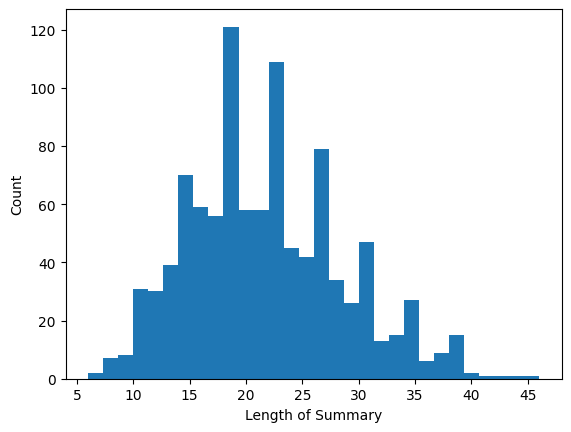

In [37]:
# Plot histogram of length column
plt.hist(test_df['len_summary'], bins=30)
# Set x and y labels
plt.xlabel('Length of Summary')
plt.ylabel('Count')

# Show the plot
plt.show()

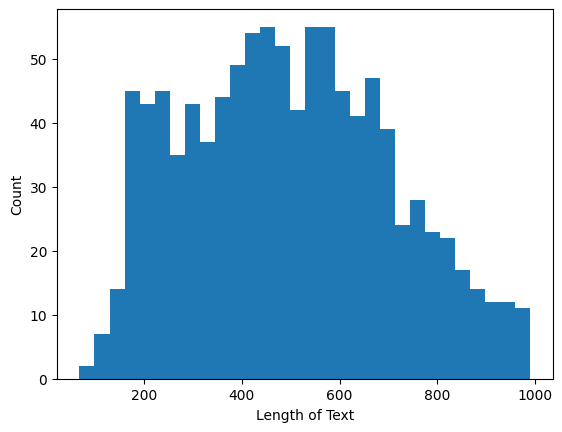

In [38]:
# Plot histogram of length column
plt.hist(test_df['len_text'], bins=30)
# Set x and y labels
plt.xlabel('Length of Text')
plt.ylabel('Count')

# Show the plot
plt.show()

## **Model and Tokenizer**

In [39]:
MODEL_NAME = 'csebuetnlp/banglat5'

In [40]:
tokenizer = Tokenizer.from_pretrained(MODEL_NAME,use_fast=False)
LModel = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME,return_dict=True)


## **DataLoader**

In [41]:
class BengaliDataset(Dataset):
  def __init__(self,data : pd.DataFrame,tokenizer : Tokenizer,source_max_token_len : int = 512,target_max_token_len : int = 40):

    self.tokenizer = tokenizer
    self.data = data
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]
    text = data_row['text']
    summary = data_row['summary'] 
    

    source_encoding = tokenizer(
        normalize(text),
        max_length = self.source_max_token_len,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt")
    
    target_encoding = tokenizer(
        normalize(summary),
        max_length = self.target_max_token_len,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt")
    
    labels = target_encoding["input_ids"]
    labels[labels == 0] = -100

    return dict(
        text_input_ids = source_encoding['input_ids'].flatten(),
        text_attention_mask = source_encoding['attention_mask'].flatten(),
        labels = labels.flatten(),
        labels_attention_mask = target_encoding["attention_mask"].flatten())


In [42]:
class BengaliDataModule(pl.LightningDataModule):
  def __init__(self,train_df : pd.DataFrame,val_df : pd.DataFrame,test_df : pd.DataFrame,tokenizer : Tokenizer,batch_size : int = 8,source_max_token_len : int = 512,target_max_token_len : int = 40):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = BengaliDataset(self.train_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.val_dataset = BengaliDataset(self.val_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.test_dataset = BengaliDataset(self.test_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=4)   

In [43]:
class BengaliSummaryModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = LModel
    
    def forward(self,input_ids,attention_mask,decoder_attention_mask, labels=None):
        
        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels
        )
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("train_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("val_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("test_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        return AdamW(self.parameters(),lr = 0.0001)

In [44]:
BATCH_SIZE = 2
N_EPOCHS = 5

data_module = BengaliDataModule(train_df,val_df,test_df,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

In [45]:
model = BengaliSummaryModel()

In [46]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

In [47]:
trainer = pl.Trainer(devices=1, accelerator="gpu",
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 247 M 
-----------------------------------------------------
247 M     Trainable params
0         Non-trainable params
247 M     Total params
990.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 4048: 'val_loss' reached 3.26827 (best 3.26827), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 8096: 'val_loss' reached 3.20040 (best 3.20040), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 12144: 'val_loss' reached 2.79257 (best 2.79257), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 16192: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 20240: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [49]:
cppath = '/content/checkpoints/best_cp.ckpt'

In [ ]:
trained_model = BengaliSummaryModel.load_from_checkpoint(cppath)
trained_model.freeze()


trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.844741106033325     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
def summarize_text(text):
    text_encoding = tokenizer(
        normalize(text),
        max_length = 512,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt")
    
    generated_ids = trained_model.model.generate(
        input_ids = text_encoding["input_ids"],
        max_length=40,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    preds = [tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
             for gen_id in generated_ids]
    
    summary = " ".join(preds)

    return summary



In [ ]:

sample_row = test_df.iloc[50]
text = sample_row["text"]
summary = summarize_text(text)

print("Actual Text : ",text)
print('----------------------------------------------------------')
print("Actual : ",sample_row["summary"])
print("----------------------------------------------------------")
print("Predicted : ",summary)